In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV
import pandas as pd

from sklearn.model_selection import train_test_split

# Problem Description
* Each image has multiple blood cells in it. On average it would probably be 10 cells per image.
* The cell-of-interest is colored purple while other cells are colored skin-red.
* One cell-of-interest per image
* **Goal**: Identify the cell-type of cell-of-interest

**Note**: For the scope of this work, only the data contained inside '`../input/dataset2-master/dataset2-master/images` directory is considered. There are some more images inside `../input/dataset-master/dataset-master/images` directory which I assumed did not exist.

# Quick Results Summary

I was able to train a CNN network from scratch (no pre-trained network used) that **has ~97% accuracy on the validation set**. The network had around 16,000 parameters and was trained for 1,000 epochs. Overall, the trained network file storage size is ~200kB and can be [found here](https://github.com/govindnh4cl/kaggle_blood_cells/blob/master/kaggle_blood_cells/100_4_model_e1000.h5.py)

**Note**: For further insight or reproducibility, check out [this Bitbucket repository](https://bitbucket.org/govindnh4cl/bloodcells).

# Manual Identification
* **Limphocyte**: looks like well rounded purple colored potato. These are the easiest to identify.
* **Monocyte**: The cell shape lookes roundish with skin-red color with some purple stuff inside. However the purple color is never fully covering the cell surface. Also, the purple colored portion of the cell is always in one continuous piece.
* **Neutrophi**l: The cell shape lookes roundish with skin-red color with some purple stuff inside. However the cell contains purple colored multiple whole-groundnuts inside it. The groundnuts could be disjointed within the cell.
* **Eosinophil**: They look like Neutrophils. Alas! See the confusion matrix published by [paultimothymooney](https://www.kaggle.com/paultimothymooney). In [his kernel](https://www.kaggle.com/paultimothymooney/identify-blood-cell-subtypes-from-images), most of the failures happen when predictor falsly thinks that Eosinophils are Neutrophils. 

Below are some example pictures. The code is copied from [paultimothymooney](https://www.kaggle.com/paultimothymooney)'s work.

In [11]:
in_dir = './data/.dataset2-master/images'

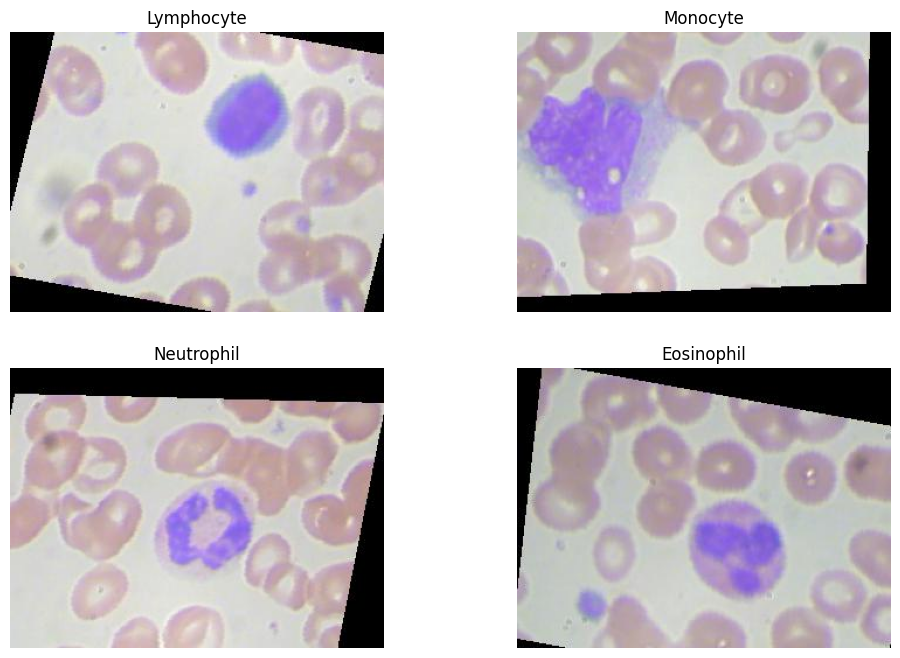

In [12]:
# Plot Image
def plotImage(image_path):
    image = cv2.imread(image_path)  # BGR
    image = image[:, :, [2, 1, 0]]  # Reorder to RGB for Matplotlib display
    plt.imshow(image)
    return

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('Lymphocyte'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/LYMPHOCYTE/_0_204.jpeg'))
plt.subplot(222)
plt.title('Monocyte'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/MONOCYTE/_0_9309.jpeg'))
plt.subplot(223)
plt.title('Neutrophil'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/NEUTROPHIL/_0_9742.jpeg'))
plt.subplot(224)
plt.title('Eosinophil'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/EOSINOPHIL/_5_907.jpeg'))

Next, summary of training and test samples.

In [6]:
print('Training samples:')
train_dir = os.path.join(in_dir, "TRAIN")
num_samples = 0
for cell in os.listdir(train_dir):
    num_cells = len(os.listdir(os.path.join(train_dir, cell)))
    num_samples += num_cells
    print('Cell: {:15s}  num samples: {:d}'.format(cell, num_cells))
print('Total training samples: {:d}\n'.format(num_samples))

print('Test samples:')
test_dir = os.path.join(in_dir, "TEST")
num_samples = 0
for cell in os.listdir(test_dir):
    num_cells = len(os.listdir(os.path.join(test_dir, cell)))
    num_samples += num_cells
    print('Cell: {:15s}  num samples: {:d}'.format(cell, num_cells))
print('Total test samples: {:d}'.format(num_samples))

Training samples:
Cell: EOSINOPHIL       num samples: 2497
Cell: LYMPHOCYTE       num samples: 2483
Cell: MONOCYTE         num samples: 2478
Cell: NEUTROPHIL       num samples: 2499
Total training samples: 9957

Test samples:
Cell: EOSINOPHIL       num samples: 623
Cell: LYMPHOCYTE       num samples: 620
Cell: MONOCYTE         num samples: 620
Cell: NEUTROPHIL       num samples: 624
Total test samples: 2487


In [7]:
def plot_learning_curves(exp_id):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df[exp_id + '_epoch'][:200], df[exp_id + '_loss'][:200], label='Train', color='black')
    plt.plot(df[exp_id + '_epoch'][:200], df[exp_id + '_val_loss'][:200], label='Validation', color='blue')
    plt.legend(); plt.xlabel('Epochs -->'); plt.ylabel('Loss -->')

    plt.subplot(1, 2, 2)
    plt.plot(df[exp_id + '_epoch'][:200], df[exp_id + '_acc'][:200], label='Train', color='black')
    plt.plot(df[exp_id + '_epoch'][:200], df[exp_id + '_val_acc'][:200], label='Validation', color='blue')
    plt.legend(); plt.xlabel('Epochs -->'); plt.ylabel('Accuracy -->');

# Preprocessing
**Image Resolution**: I scaled all my images to 160x120 (wdxht). Reason: My GPU has only 2 GB internal memory. The cryptocurrency bubble in the first quarter of 2018 has pushed the prices of GPUs way to high. I can't upgrade. So I can't train with original or larger image size.

For my experimentation, I used 10% of training data as validation set. And yes, the split was [stratified](https://stackoverflow.com/a/38889389).

**Image Normalization**: I normalized every pixel location over entire training dataset (validation set wasn't used). This way I have a mean and a std. image. For each image in the dataset, I first subtract mean image with it and then I divide it with the std. image.



# Training Attempts

### Training a simple model:

To start with, I tried to use a simple model with just ~5000 trainable parameters. Since the training set is limited to ~12,500 images, it is expected that a neural network would try to take the easy route and overfit.

```
x = Conv2D(4, 5, strides=(4, 4), padding='same', activation='relu')(inputs)
x = Conv2D(4, 5, strides=(4, 4), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(4, activation='softmax')(x)
        
_______________________________________________________________
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
input_1 (InputLayer)         (None, 120, 160, 3)       0         
conv2d_1 (Conv2D)            (None, 30, 40, 4)         304       
conv2d_2 (Conv2D)            (None, 8, 10, 4)          404       
flatten_1 (Flatten)          (None, 320)               0         
dense_1 (Dense)              (None, 16)                5136      
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
Total params: 5,912
Trainable params: 5,912
Non-trainable params: 0
```
Even for this simple model used for this experiment, the training starts overfitting somewhere between 25-50 epochs. The training accuracy continues to increase while validation accuracy saturates around 70%.

### Training a Simple Model + Regularization

To counter the overfitting, I ran an experiment with a **Dropout** of 20% after all layers. The Dropout successfully eliminates the overfitting problem. The validation loss does not bend in U-shape and **the valudation accuracy saturates way above (compared to no Dropout) at around 80%.**

**Note**: The training loss is higher than validation loss because Dropout randomly sets activation units to zero during training phase, making the train phase harder. During validation, the Dropout is disabled and hence all units are active.

It may look like the loss was still going down at the end of 200 epochs, and continuing for more epochs could have trained our model perfectly. However, I did train the model for 1000 epochs. The Dropout still managed to prevent overfitting but validation accuracy stayed saturated at around 80%.

**A comment on model capacity**: The saturation of validation accuracy is understandble. The capacity (e.g. number of layers, number of units etc.) of the model is lower than the ideal capacity required to represent the decision function. The above model only had 2 Conv layers and 2 Fully-Connected layers. Such low capacity may only be capable of giving us 80% accuracy, and in order to attain a higher accuracy <em>we must match our model's capacity with the complexity of the problem</em>.

Since we can't get a quantitave measure of the complexity of problem just by looking at it, we never know the ideal model capacity that would work best. However, an experienced person, who has solved similar problems in the past can come make a good guess. In my case, I did some trial and experimentation, and found that this model works:

```
x = Conv2D(16, 5, strides=(2, 2), padding='same', activation='relu')(inputs)
x = Conv2D(8, 5, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
input_1 (InputLayer)         (None, 120, 160, 3)       0         
conv2d_1 (Conv2D)            (None, 60, 80, 16)        1216      
conv2d_2 (Conv2D)            (None, 30, 40, 8)         3208      
conv2d_3 (Conv2D)            (None, 15, 20, 4)         804       
conv2d_4 (Conv2D)            (None, 8, 10, 4)          404       
flatten_1 (Flatten)          (None, 320)               0         
dense_1 (Dense)              (None, 32)                10272     
dense_2 (Dense)              (None, 16)                528       
dense_3 (Dense)              (None, 8)                 136       
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
Total params: 16,604
Trainable params: 16,604
Non-trainable params: 0
```

As expected, this model overfits on the dataset. **The training accuracy goes ~100% while validation accuracy saturates at ~82%**. See learning curves below:

To prevent overfitting I used Dropout again. Now, the validation loss keeps droping with epochs. **The validation accuracy goes ~92% in 200 epochs.**

### Final Model

Below is the summary of best performing model from my experimentations.
```
    x = Conv2D(16, 5, strides=(2, 2), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(8, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='softmax')(x)

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    _________________________________________________________________
    input_1 (InputLayer)         (None, 120, 160, 3)       0         
    conv2d_1 (Conv2D)            (None, 60, 80, 16)        1216      
    batch_normalization_1 (Batch (None, 60, 80, 16)        64        
    dropout_1 (Dropout)          (None, 60, 80, 16)        0         
    conv2d_2 (Conv2D)            (None, 30, 40, 8)         3208      
    batch_normalization_2 (Batch (None, 30, 40, 8)         32        
    dropout_2 (Dropout)          (None, 30, 40, 8)         0         
    conv2d_3 (Conv2D)            (None, 15, 20, 4)         804       
    batch_normalization_3 (Batch (None, 15, 20, 4)         16        
    dropout_3 (Dropout)          (None, 15, 20, 4)         0         
    conv2d_4 (Conv2D)            (None, 8, 10, 4)          404       
    batch_normalization_4 (Batch (None, 8, 10, 4)          16        
    dropout_4 (Dropout)          (None, 8, 10, 4)          0         
    flatten_1 (Flatten)          (None, 320)               0         
    dense_1 (Dense)              (None, 32)                10272     
    dropout_5 (Dropout)          (None, 32)                0         
    dense_2 (Dense)              (None, 16)                528       
    dropout_6 (Dropout)          (None, 16)                0         
    dense_3 (Dense)              (None, 8)                 136       
    dropout_7 (Dropout)          (None, 8)                 0         
    dense_4 (Dense)              (None, 4)                 36        
    _________________________________________________________________
    Total params: 16,732
    Trainable params: 16,668
    Non-trainable params: 64
```

This model was trained for 1000 epochs And the **validation accuracy saturates at around 97%.**

```
Train       : Loss = 0.023    Accuracy = 99.53%
Validation  : Loss = 0.063    Accuracy = 97.09%
```

Before listing this model's performance on the test-set, I would list the results of some of my other experiments.

# Effect of Hyperparameters

Next, I am going to look into the effect of a few hyperparameters on this model's performance. I kept the core layers fixed and varied one hyperparameter isolatedly in each experiment. **All experiments below used Dropout, Batch Normalization, ReLU activation, Softmax output and Categrorical-Crossentropy loss unless specifically mentioned.**

### Effect of Image Normalization

**Type 0**: Normalize individual dimension (pixel location) across entire training data. Uses a mean and std image (shown above) for normalization. **Default**

**Type 1**: No normalization.

**Type 2**: Normalized each images independently. Each channel inside that image is also normalized independently.

**Type 3**: Just scale pixel values (0, 255) to range (-1, +1)

As plot shows below, Unnormalized input (Type 1) is a disaster for the validation set performance. And so is just scaling the pixels to range (-1, +1) (Type 3). While it is expected that pixel-location normalization (Type 0) would work best, I didn't expect that normalizing each independently (Type 2) would be good as well.

### Effect of Batch Normalization

I found that Batch Normalization improved the speed of convergence. Looking at the learning curve, it may appear that Batch Normalization produces a loss that is constantly lower than no Batch Normalization. However, both of these model do converge to approximately equal loss if continued to train for 1000 epochs.

**Note**: In the original Batch Normalization paper "[Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)" by Sergey Ioffe and Christian Szegedy, it is stated that "<em>The resulting networks [with Batch Normalization] can be trained with saturating nonlinearities, are more tolerant to increased training rates, and often do not require Dropout for regularization</em>". However, in my experiments, Batch Normalization alone wasn't enough to stop overfitting. Dropout was utmost important. The only benifit of Batch Normalization that I found was **faster convergence: the network always arrived at a lower validation loss in less epochs with Batch Normalization**.

### Effect of Dropout Amount

**Note**: It may look like the Dropout=0.1 gives better results than Dropout=0.2. However, Dropout=0.1 does not have strong enough regularization effect compared to Dropout=0.2. As shown in plots below, the training loss for Dropout=0.1 stays below validation loss, and gets close to 0 when number of epochs are increased to 1000. This stops the learning process as there is no significant taining error left to minimize. On the other hand, the model with Dropout=0.2 has a training loss higher than the validation loss and hence keeps improving till 1000 epochs. As a result, after 1000 epochs, the validatio loss of Dropout=0.2 is lower than that of Dropout=0.1

### Effect of Optimizers

### Effect of Activation Functions

### Effect of Filter size of Convolution Layers 

# Evaluation on Test Set

Code below is provided for reference. The kernel on kaggle is too slow to load the model from filesystem within my patience limit.

In [ ]:
class Data:
    def __init__(self, batch_size):
        self.in_ht, self.in_wd = 240, 320
        self.out_ht, self.out_wd = int(self.in_ht / 2), int(self.in_wd / 2)
        self.vld_portion = 0.1
        self.batch_size = {'TRAIN': batch_size, 'VALIDATION': batch_size, 'TEST': 1}
        self.in_dir = in_dir

        self.id2cell = pd.Series(os.listdir(os.path.join(self.in_dir, 'TRAIN')))
        self.cell2id = pd.Series(range(len(self.id2cell)), index=self.id2cell)

        self.x_trn_list, self.x_vld_list, self.y_trn, self.y_vld = self._get_names_labels(phase='TRAIN')
        self.x_tst_list, self.y_tst = self._get_names_labels(phase='TEST')
        self.steps_per_epoch = int(np.ceil(len(self.x_trn_list)/self.batch_size['TRAIN']))
        self.validation_steps = int(np.ceil(len(self.x_vld_list)/self.batch_size['TRAIN']))
        self.test_steps = int(np.ceil(len(self.x_tst_list)/self.batch_size['TEST']))        

        self.mean_img, self.std_img = self._get_stat_images()

    def _get_names_labels(self, phase):
        in_dir = os.path.join(self.in_dir, phase)
        if not os.path.exists(in_dir):
            raise IOError('Error: Directory {:s} does not exist.'.format(in_dir))

        x = list()
        labels = dict()
        for cell_id in self.id2cell.index:
            img_dir = os.path.join(in_dir, self.id2cell[cell_id])
            img_names = [a for a in os.listdir(img_dir) if a.endswith('.jpeg')]
            img_paths = [os.path.join(img_dir, img_name) for img_name in img_names]
            x += img_paths
            labels[cell_id] = np.zeros([len(img_paths), len(self.id2cell)], dtype=bool)  # One hot vector
            labels[cell_id][:, cell_id] = True

        y = np.concatenate([labels[a] for a in self.id2cell.index])
        
        if phase == 'TRAIN':
            trn_x_list, vld_x_list, y_trn, y_vld = \
                train_test_split(x, y, test_size=self.vld_portion, random_state=42, stratify=y, shuffle=True)

            return trn_x_list, vld_x_list, y_trn, y_vld
        else:
            return x, y

    def get_batch(self, phase):
        if phase == 'TRAIN':
            x_list = self.x_trn_list
            y = self.y_trn
        elif phase == 'VALIDATION':
            x_list = self.x_vld_list
            y = self.y_vld
        else:
            x_list = self.x_tst_list
            y = self.y_tst        

        # Allocated one-time memory for the batch
        x_batch = np.zeros((self.batch_size[phase], self.out_ht, self.out_wd, 3), dtype=float)
        y_batch = np.zeros((self.batch_size[phase], len(self.cell2id)), dtype=bool)

        src_idx = 0
        dst_idx = 0
        while True:
            img_path = x_list[src_idx]
            img = cv2.imread(img_path)
            if img is None:
                raise self.DataBatchError("Error: Can't open image: {:s}".format(img_path))

            img = cv2.resize(img, (self.out_wd, self.out_ht)).astype(float)

            # Normalize the image: Normalize each dimension
            img = (img - self.mean_img) / self.std_img            

            x_batch[dst_idx] = img
            y_batch[dst_idx] = y[src_idx]
            src_idx += 1
            dst_idx += 1

            if src_idx >= len(x_list):
                src_idx = 0

            if dst_idx >= self.batch_size[phase]:
                dst_idx = 0
                yield x_batch.copy(), y_batch.copy()

    def _get_stat_images(self):
        mean_img_path = os.path.join(resource_dir, 'mean_image_{:d}x{:d}.npy.py'.format(self.out_wd, self.out_ht))
        std_img_path = os.path.join(resource_dir, 'std_image_{:d}x{:d}.npy.py'.format(self.out_wd, self.out_ht))
        mean_img = np.load(mean_img_path)
        std_img = np.load(std_img_path)
        return mean_img, std_img
    
data = Data(batch_size=16)
model_path = os.path.join(in_dir, '100_4_model_e1000.h5.py')

In [ ]:
m = load_model(model_path)

eval_out = m.evaluate_generator(data.get_batch('TRAIN'), steps=data.test_steps)
print('Train performance: ', eval_out)

eval_out = m.evaluate_generator(data.get_batch('VALIDATION'), steps=data.test_steps)
print('Validation performance: ', eval_out)

eval_out = m.evaluate_generator(data.get_batch('TEST'), steps=data.test_steps)
print('Test performance: ', eval_out)

```python
m = load_model(model_path)

eval_out = m.evaluate_generator(data.get_batch('TRAIN'), steps=data.test_steps)
print('Train performance: ', eval_out)

eval_out = m.evaluate_generator(data.get_batch('VALIDATION'), steps=data.test_steps)
print('Validation performance: ', eval_out)

eval_out = m.evaluate_generator(data.get_batch('TEST'), steps=data.test_steps)
print('Test performance: ', eval_out)

```

### Evaluation Results
Here is the summary of the model performance on Training, Validation and Test set:
```
Train       : Loss = 0.023    Accuracy = 99.53%
Validation  : Loss = 0.063    Accuracy = 97.09%
Test        : Loss = 1.702    Accuracy = 83.76%
```

**The test performance is way worse than the training and validation set. **

I could think of following reasons for this:

1) **Bad Experimentation**: [Stephan Kolassa](https://stats.stackexchange.com/users/1352/stephan-kolassa)'s  [Stackoverflow answer](https://stats.stackexchange.com/a/309818) explains this possibility well:
> You may be "overfitting to the validation set" at this step:
> 
> > chose the best model based on best accuracy using a separate validation set
> 
> Once you tweak your model, or choose among multiple competing models based on the validation set, it is not a true validation set any more - it effectively becomes part of the training set, albeit in a somewhat obfuscated way.
> 
> Look at it in this way: suppose you train an astronomical number of models, including all your potential predictors, but also transformations, and completely unrelated predictors like sunspot numbers or frequencies of [Mongolian throat singers](https://www.youtube.com/results?search_query=mongolian+throat+singing). Then you apply all your models to the validation set and choose the one model that performs best on the validation set. This one happens to include an interaction term between last year's precipitation in [Nowhere, OK](https://en.wikipedia.org/wiki/Nowhere,_Oklahoma) and the hemlines at this year's Paris fashion shows - simply because you are fitting noise.
> 
> Would you expect this model to perform well on holdout test data, simply because it "worked" best on the validation set?
> 
> Unfortunately, there really is no good way around this dilemma. This can even happen with cross-validation and regularization or tree pruning. Differences between accuracy on different test and validation sets are one potential hint that something like this is going on, though. Your best approach would be to be parsimonious in your initial selection of candidate models, and collecting a lot of test data so you can use a "layered" approach with multiple iterated validation and test sets.

I don't like this possibility, since it puts me in a 'chicken vs. egg' problem. I am supposed to tune my hyperparameters based on a validation set (or a k-fold cross-validation). But that's cheating as I can try "astronomical" number of such models and choose the one which performs best on validation set? And since the winner model has been tuned highly to perform best on validation set/s it wouldn't generalize to test set well. But hey, I didn't try "astronomical" number of models. I can understand the "overfitting to the validation set" is always present in the Machine Learning world and the test-set performance gives the true unbiased estimate of model's performance, however, a 14% difference in accuracy is too much! So, here comes the next explanation to bad test-set performance:

2) **Bad Dataset**: The dataset might not have been shuffled properly before dividing into train-test sets. Such bad shuffling could have resulted in easy samples going in the training set. Or, maybe the test data wasn't created by shuffling a base dataset and the distribution of samples in test set is different than training set. If this is so, then no matter what Machine Learning algorithm is used, the test-performance cannot be improved.

-------------------------------------------------------

EDIT: As [S.Hu](https://www.kaggle.com/shueeg) has pointed out in the comment stream below, the dataset contains augmented images from the same set of input images. If the train and validation set were created from the same set of images but the test set was created from a different set of imaes, then we expect the test-set performance to be worse than that of train/validation set. I couldn't find a way to figure out which original images the train/validation/test sets were derived. So I can't proceed on that path. I tried to take a cue from the filenames i.e. maybe `_2_9132.jpeg`, `_2_9132.jpeg` and` _2_9404.jpeg` are taken from the same source file. Therefore if I place all images prefixed with `_2` into the validation set, then the validation set could represent the true test-set distribution. However, this didn't change any of the results and the test performance stayed low.

-------------------------------------------------------